In [57]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout,Flatten
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.models import load_model

In [58]:
################ PARAMETERS ########################
path = 'myData'
testRatio = 0.2
valRatio = 0.2
imageDimensions= (32,32,3)
batchSizeVal= 50
epochsVal = 10
stepsPerEpochVal = 2000
####################################################

In [59]:
#### IMPORTING DATA/IMAGES FROM FOLDERS
count = 0
images = []     # LIST CONTAINING ALL THE IMAGES
classNo = []    # LIST CONTAINING ALL THE CORRESPONDING CLASS ID OF IMAGES
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses = len(myList)
print("Importing Classes .......")
for x in range (0,noOfClasses):
    myPicList = os.listdir(path+"/"+str(x))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg,(32,32))
        images.append(curImg)
        classNo.append(x)
    print(x,end= " ")
print(" ")
print("Total Images in Images List = ",len(images))
print("Total IDS in classNo List= ",len(classNo))

Total Classes Detected: 10
Importing Classes .......
0 1 2 3 4 5 6 7 8 9  
Total Images in Images List =  10160
Total IDS in classNo List=  10160


In [60]:
#### CONVERT TO NUMPY ARRAY
images = np.array(images)
classNo = np.array(classNo)
print(images.shape)

(10160, 32, 32, 3)


In [61]:
#### SPLITTING THE DATA
X_train,X_test,y_train,y_test = train_test_split(images,classNo,test_size=testRatio)
X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=valRatio)
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(6502, 32, 32, 3)
(2032, 32, 32, 3)
(1626, 32, 32, 3)


[647, 643, 651, 652, 643, 629, 673, 660, 641, 663]


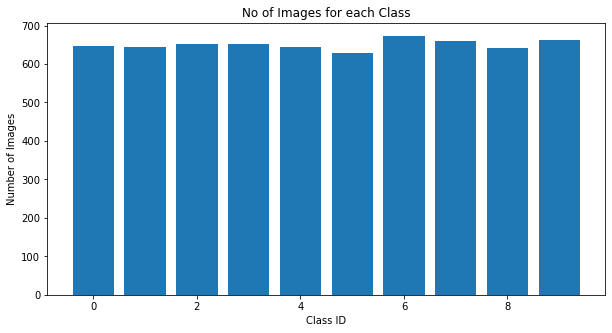

In [62]:
#### PLOT BAR CHART FOR DISTRIBUTION OF IMAGES
numOfSamples= []
for x in range(0,noOfClasses):
    #print(len(np.where(y_train==x)[0]))
    numOfSamples.append(len(np.where(y_train==x)[0]))
print(numOfSamples)

plt.figure(figsize=(10,5))
plt.bar(range(0,noOfClasses),numOfSamples)
plt.title("No of Images for each Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

In [63]:
#### PREPOSSESSING FUNCTION FOR IMAGES FOR TRAINING
def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img
# img = preProcessing(X_train[30])
# img = cv2.resize(img,(300,300))
# cv2.imshow("PreProcesssed",img)
# cv2.waitKey(0)

In [64]:
X_train= np.array(list(map(preProcessing,X_train)))
X_test= np.array(list(map(preProcessing,X_test)))
X_validation= np.array(list(map(preProcessing,X_validation)))

In [65]:
#### RESHAPE IMAGES
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)

In [66]:
#### IMAGE AUGMENTATION
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)

In [67]:
#### ONE HOT ENCODING OF MATRICES
y_train = to_categorical(y_train,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)

In [68]:
#### CREATING THE MODEL
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3, 3)
    sizeOfPool = (2,2)
    noOfNodes= 500

    model = Sequential()
    model.add((Conv2D(noOfFilters,sizeOfFilter1,input_shape=(imageDimensions[0],
                                                             imageDimensions[1],1),activation='relu')))
    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(noOfNodes,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))

    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [69]:
model = myModel()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 30)          0

Epoch 1/10
2000/2000 [==============================] - 1685s 843ms/step - loss: 0.2592 - accuracy: 0.9131 - val_loss: 0.0174 - val_accuracy: 0.9957
Epoch 2/10
2000/2000 [==============================] - 1670s 835ms/step - loss: 0.0724 - accuracy: 0.9773 - val_loss: 0.0130 - val_accuracy: 0.9988
Epoch 3/10
2000/2000 [==============================] - 1678s 839ms/step - loss: 0.0562 - accuracy: 0.9822 - val_loss: 0.0103 - val_accuracy: 0.9975
Epoch 4/10
2000/2000 [==============================] - 1652s 826ms/step - loss: 0.0417 - accuracy: 0.9869 - val_loss: 0.0089 - val_accuracy: 0.9975
Epoch 5/10
2000/2000 [==============================] - 1568s 784ms/step - loss: 0.0364 - accuracy: 0.9886 - val_loss: 0.0188 - val_accuracy: 0.9957
Epoch 6/10
2000/2000 [==============================] - 1717s 859ms/step - loss: 0.0327 - accuracy: 0.9902 - val_loss: 0.0090 - val_accuracy: 0.9988
Epoch 7/10
2000/2000 [==============================] - 1702s 851ms/step - loss: 0.0282 - accuracy: 0.9915

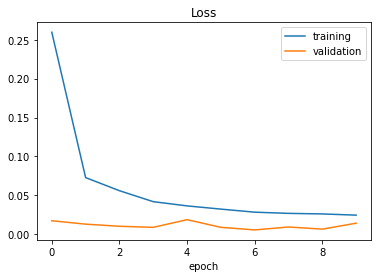

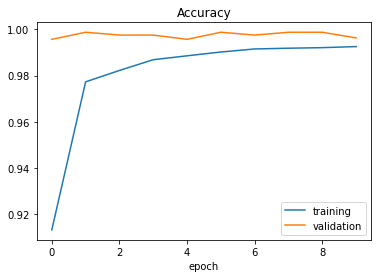

In [70]:
#### STARTING THE TRAINING PROCESS
history = model.fit_generator(dataGen.flow(X_train,y_train,
                                           batch_size=batchSizeVal),
                              steps_per_epoch=stepsPerEpochVal,
                              epochs=epochsVal,
                              validation_data=(X_validation,y_validation),
                              shuffle=1)

#### PLOT THE RESULTS
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [71]:
#### EVALUATE USING TEST IMAGES
score = model.evaluate(X_test,y_test,verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.019777658207947562
Test Accuracy = 0.996063


In [86]:
#### SAVE THE TRAINED MODEL
model.save('my_model');

INFO:tensorflow:Assets written to: my_model/assets


In [87]:
### LOAD THE MODEL
model_1 = load_model('my_model')

Class label : 6
100.0


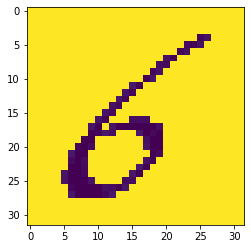

In [98]:
### TEST THE MODEL
img=X_test[1].reshape(1,32,32,1)
plt.imshow(X_test[1])
print('Class label :',model_1.predict_classes(img)[0])
prediction =model_1.predict(img)
print(np.amax(prediction)*100)